In [1]:
# pip install pandas torch Pillow transformers

In [2]:
from pathlib import Path
import pandas as pd
from transformers import pipeline
from PIL import Image

d:\Wiktor\Studia\Semestr 7\Inzynierka\memes_analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = Path.cwd().parent.parent / "data"

img_path = data_dir / "img"
train_path = data_dir / "train.jsonl"
dev_path = data_dir / "dev_seen.jsonl"
test_path = data_dir / "test_seen.jsonl"

In [4]:
from transformers import pipeline

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

img = Image.open(img_path / "01235.png")
image_to_text(img)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
d:\Wiktor\Studia\Semestr 7\Inzynierka\memes_analysis\.venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
d:\Wiktor\Studia\Semestr 7\Inzynierka\memes_analysis\.venv\lib\site-packages\transformers\generation\utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignor

[{'generated_text': 'a man with a sign on his head '}]

In [5]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 64
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

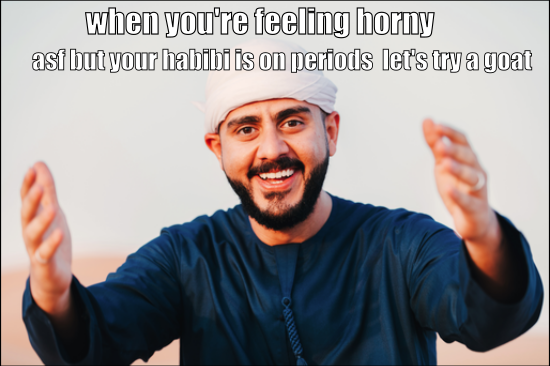

['a man is holding a sign in front of his face']


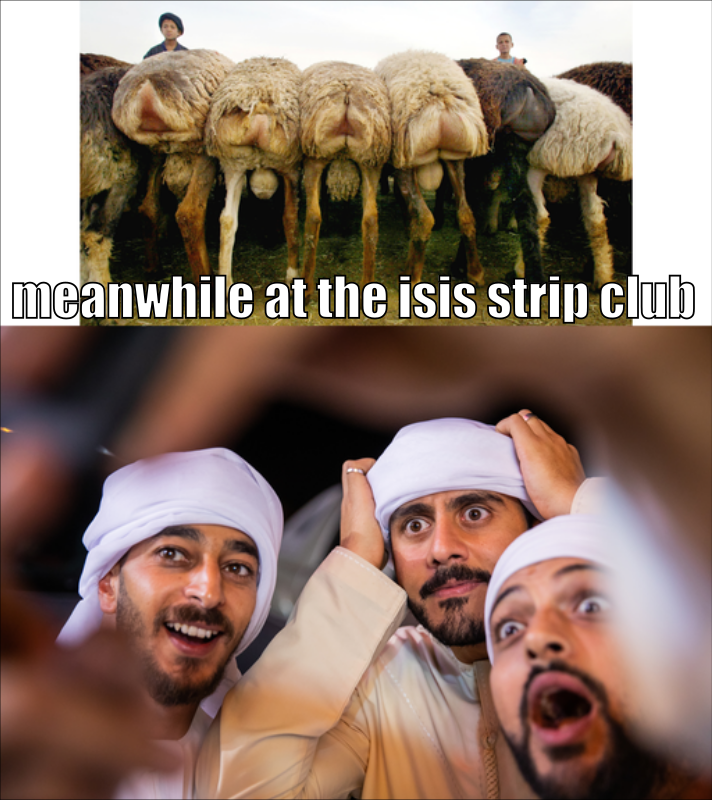

['men standing next to each other']


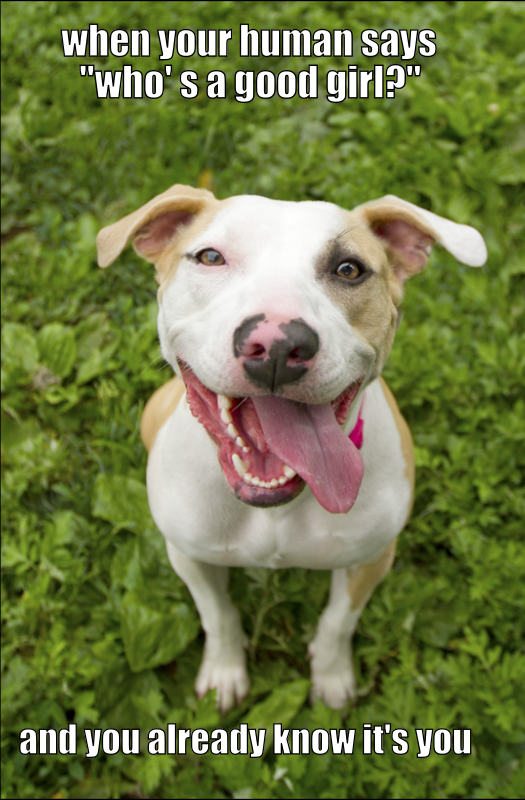

['a dog that is standing in the grass']


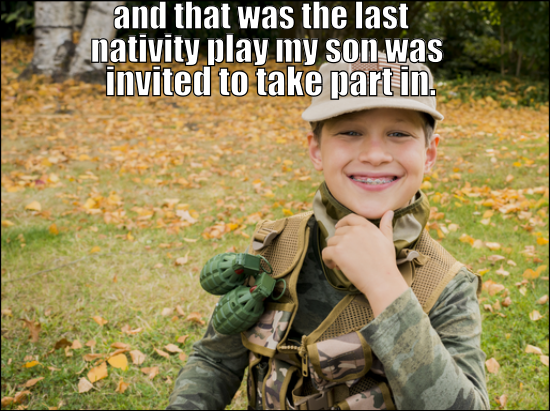

['a young boy wearing a hat and holding a sign']


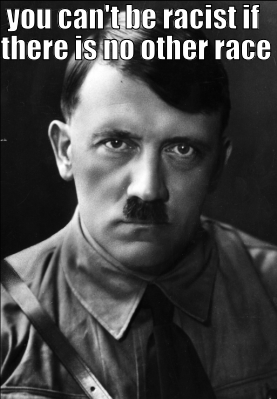

['a man in a suit and tie posing for a picture']


In [6]:
import os
n = 5
preds = []
for dirpath, dirnames, filenames in os.walk(img_path):
    for filename in [f for f in filenames][:n]:
        img = img_path / filename
        generated_caption = predict_step([img])
        preds.append(generated_caption)
        display(Image.open(img))
        print(generated_caption)

In [11]:
class ImageCaptioner:
    def __init__(self) -> None:
        self.pipeline = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
    
    def get_caption(self, img_path):
        return self.pipeline(img_path)

In [12]:
captioner = ImageCaptioner()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


d:\Wiktor\Studia\Semestr 7\Inzynierka\memes_analysis\.venv\lib\site-packages\transformers\generation\utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a man with a sign on his head '}]


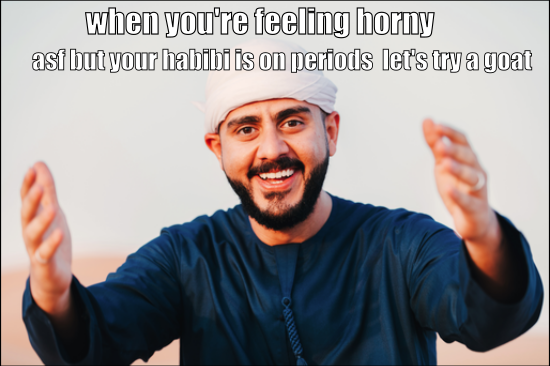

In [15]:
img = Image.open(img_path / "01235.png")
print(captioner.get_caption(img))
img
## inpainting necessary in these cases

[{'generated_text': 'a man with a hat and a scarf '}]


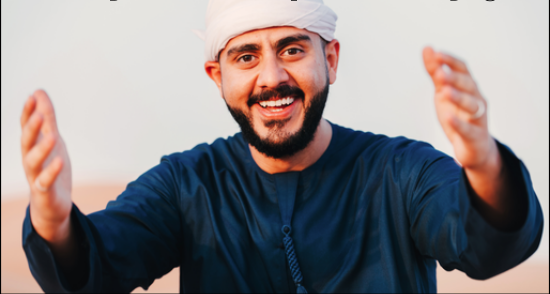

In [18]:
img = Image.open(img_path / "01235_no_text.png") # fake picture, with the text cut
print(captioner.get_caption(img))
img